# Sentiment analysis with Word2Vec

### Exercise objectives:
- Convert words to vectors with Word2Vec
- Use the word representation given by Word2vec to feed a RNN

<hr>

▶️ Run this cell and make sure the version of 📚 [Gensim - Word2Vec](https://radimrehurek.com/gensim/auto_examples/index.html) you are using is ≥ 4.0!

In [1]:
!pip freeze | grep gensim

gensim==4.3.3


# The data


❓ **Question** ❓ Let's first load the data. You don't have to understand what is going on in the function, it does not matter here.

⚠️ **Warning** ⚠️ The `load_data` function has a `percentage_of_sentences` argument. Depending on your computer, there are chances that too many sentences will make your compute slow down, or even freeze - your RAM can overflow. For that reason, **you should start with 10% of the sentences** and see if your computer handles it. Otherwise, rerun with a lower number. 

⚠️ **DISCLAIMER** ⚠️ **No need to play _who has the biggest_ (RAM) !** The idea is to get to run your models quickly to prototype. Even in real life, it is recommended that you start with a subset of your data to loop and debug quickly. So increase the number only if you are into getting the best accuracy.

In [1]:
import numpy as np

In [2]:
###########################################
### Just run this cell to load the data ###
###########################################

import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import text_to_word_sequence

def load_data(percentage_of_sentences=None):
    train_data, test_data = tfds.load(name="imdb_reviews", split=["train", "test"], batch_size=-1, as_supervised=True)

    train_sentences, y_train = tfds.as_numpy(train_data)
    test_sentences, y_test = tfds.as_numpy(test_data)

    # Take only a given percentage of the entire data
    if percentage_of_sentences is not None:
        assert(percentage_of_sentences> 0 and percentage_of_sentences<=100)

        len_train = int(percentage_of_sentences/100*len(train_sentences))
        train_sentences, y_train = train_sentences[:len_train], y_train[:len_train]

        len_test = int(percentage_of_sentences/100*len(test_sentences))
        test_sentences, y_test = test_sentences[:len_test], y_test[:len_test]

    X_train = [text_to_word_sequence(_.decode("utf-8")) for _ in train_sentences]
    X_test = [text_to_word_sequence(_.decode("utf-8")) for _ in test_sentences]

    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_data(percentage_of_sentences=3)

2025-08-19 13:12:56.554908: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-19 13:12:57.044366: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-19 13:12:57.481462: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-19 13:12:57.884186: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-19 13:12:57.885718: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-19 13:12:57.979108: I tensorflow/core/platform/cpu_feature_guard.cc:

In the previous exercise, you trained a Word2vec representation and converted all your training sentences in order to feed them into a RNN, as shown in the first step of this Figure: 

<img src="https://wagon-public-datasets.s3.amazonaws.com/data-science-images/06-DL/NLP/word2vec_representation.png" alt="Word2Vec with RNN" width="400px" />



❓ **Question** ❓ Here, let's re-do exactly what you have done in the previous exercise. First, train a word2vec model (with the arguments that you want) on your training sentence. Store it into the `word2vec` variable.

In [3]:
# YOUR CODE HERE
from gensim.models import Word2Vec

word2vec = Word2Vec(sentences=X_train, vector_size=50, min_count=3, window=10)
wv = word2vec.wv

Let's reuse the functions of the previous exercise to convert your training and test data into something you can feed into a RNN.

❓ **Question** ❓ Read the following function to be sure you understand what is going on, and run it.

In [4]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Function to convert a sentence (list of words) into a matrix representing the words in the embedding space
def embed_sentence(word2vec, sentence):
    embedded_sentence = []
    for word in sentence:
        if word in word2vec.wv:
            embedded_sentence.append(word2vec.wv[word])

    return np.array(embedded_sentence)

# Function that converts a list of sentences into a list of matrices
def embedding(word2vec, sentences):
    embed = []

    for sentence in sentences:
        embedded_sentence = embed_sentence(word2vec, sentence)
        embed.append(embedded_sentence)

    return embed

# Embed the training and test sentences
X_train_embed = embedding(word2vec, X_train)
X_test_embed = embedding(word2vec, X_test)


# Pad the training and test embedded sentences
X_train_pad = pad_sequences(X_train_embed, dtype='float32', padding='post', maxlen=200)
X_test_pad = pad_sequences(X_test_embed, dtype='float32', padding='post', maxlen=200)

☝️ To be sure that it worked, let's check the following for `X_train_pad` and `X_test_pad`:
- they are numpy arrays
- they are 3-dimensional
- the last dimension is of the size of your word2vec embedding space (you can get it with `word2vec.wv.vector_size`
- the first dimension is of the size of your `X_train` and `X_test`

✅ **Good Practice** ✅ Such tests are quite important! Not only in this exercise, but in real-life applications. It prevents from finding errors too late and from letting them propagate through the entire notebook.

In [5]:
# TEST ME
for X in [X_train_pad, X_test_pad]:
    assert type(X) == np.ndarray
    assert X.shape[-1] == word2vec.wv.vector_size


assert X_train_pad.shape[0] == len(X_train)
assert X_test_pad.shape[0] == len(X_test)

# Baseline model

It is always good to have a very simple model to test your own model against - to be sure you are doing something better than a very simple algorithm.

❓ **Question** ❓ What is your baseline accuracy? In this case, your baseline can be to predict the label that is the most present in `y_train` (of course, if the dataset is balanced, the baseline accuracy is 1/n where n is the number of classes - 2 here).

In [8]:
# YOUR CODE HERE
y_train.sum()/len(y_train)

0.5186666666666667

# The model

❓ **Question** ❓ Write a RNN with the following layers:
- a `Masking` layer
- a `LSTM` with 20 units and `tanh` activation function
- a `Dense` with 10 units
- an output layer that depends on your task

Then, compile your model (we advise you to use the `rmsprop` as the optimizer - at least to begin with)

In [11]:
# YOUR CODE HERE
from keras import Sequential, layers
from keras.layers import Dense, Input, LSTM, SimpleRNN, GRU, Embedding, Masking

def initialize_model():
    model = Sequential()
    
    model.add(Input(shape=X_train_pad.shape[1:]))

    model.add(Masking(mask_value=0))

    model.add(LSTM(20, activation='tanh'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    return model

def compile_model(model):
    model.compile(
        loss='binary_crossentropy',
        optimizer='rmsprop',
        metrics=['accuracy']
    )

    return model

❓ **Question** ❓ Fit the model on your embedded and padded data - do not forget the early stopping criterion.

❗ **Remark** ❗ Your accuracy will greatly depend on your training corpus. Here just make sure that your performance is above the baseline model (which should be the case even if you loaded only 20% of the initial IMDB data).

In [24]:
# YOUR CODE HERE
from keras.callbacks import EarlyStopping

model = initialize_model()
model = compile_model(model)
es = EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(
    X_train_pad,
    y_train,
    validation_split=0.2,
    batch_size=128,
    epochs=20,
    verbose=0,
    callbacks=es
)

2025-08-19 13:41:10.114079: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 24000000 exceeds 10% of free system memory.


❓ **Question** ❓ Evaluate your model on the test set

In [25]:
# YOUR CODE HERE
import matplotlib.pyplot as plt


def plot_history(history, metric:str):

    fig, ax = plt.subplots(1,2, figsize=(20,7))
    # --- LOSS: MSE ---
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)

    # --- METRICS:MAE ---

    ax[1].plot(history.history[metric])
    ax[1].plot(history.history[f'val_{metric}'])
    ax[1].set_title(metric)
    ax[1].set_ylabel(metric)
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='best')
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)

    return ax

array([<Axes: title={'center': 'loss'}, xlabel='Epoch', ylabel='Loss'>,
       <Axes: title={'center': 'accuracy'}, xlabel='Epoch', ylabel='accuracy'>],
      dtype=object)

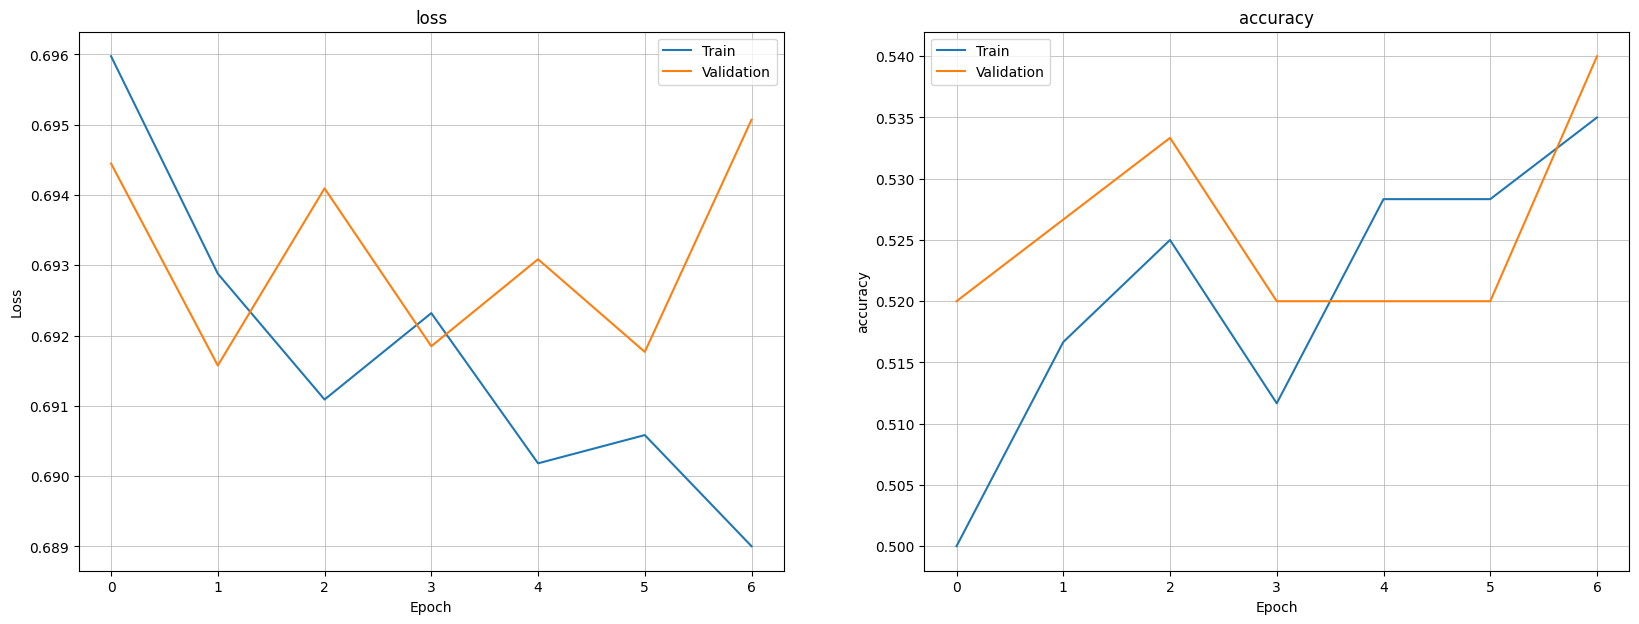

In [20]:
plot_history(history, metric='accuracy')

In [31]:
from sklearn.metrics import accuracy_score


y_pred = model.predict(X_test_pad)
print('model accuracy:',accuracy_score(np.array([1 if x > 0.5 else 0 for x in y_pred]), y_test ))
print('baseline accuracy:',accuracy_score(np.ones(len(y_test)), y_test ))

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
model accuracy: 0.5093333333333333
baseline accuracy: 0.5066666666666667


# Trained Word2Vec - Transfer Learning

Your accuracy, while above the baseline model, might be quite low. There are multiple options to improve it, as data cleaning and improving the quality of the embedding.

We won't dig into data cleaning strategies here. Let's try to improve the quality of our embedding. But instead of just loading a larger corpus, why not benefiting from the embedding that others have learned? Because, the quality of an embedding, i.e. the proximity of the words, can be derived from different tasks. This is exactly what transfer learning is.



❓ **Question** ❓ List all the different models available in the word2vec thanks to this: 

In [21]:
import gensim.downloader as api
print(list(api.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


ℹ️ You can also find the list of the models and their size on the [`gensim-data` repository](https://github.com/RaRe-Technologies/gensim-data#models).

❓ **Question** ❓ Load one of the pre-trained word2vec embedding spaces. 

You can do that with `api.load(the-model-of-your-choice)`, and store it in `word2vec_transfer`

<details>
    <summary>💡 Hint</summary>
    
The `glove-wiki-gigaword-50` model is a good candidate to start with as it is smaller (65 MB).

</details>

In [34]:
# YOUR CODE HERE
word2vec_transfer = api.load('glove-wiki-gigaword-50')

[==================================================] 100.0% 66.0/66.0MB downloaded


❓ **Question** ❓ Check the size of the vocabulary, but also the size of the embedding space.

In [43]:
# YOUR CODE HERE
# word2vec_transfer['dog']

len(word2vec_transfer['dog'])
len(word2vec_transfer)

400000

❓ Let's embed `X_train` and `X_test`, same as in the first question where we provided the functions to do so! (There is a slight difference in the `embed_sentence_with_TF` function that we will not dig into)

In [44]:
# Function to convert a sentence (list of words) into a matrix representing the words in the embedding space
def embed_sentence_with_TF(word2vec, sentence):
    embedded_sentence = []
    for word in sentence:
        if word in word2vec:
            embedded_sentence.append(word2vec[word])

    return np.array(embedded_sentence)

# Function that converts a list of sentences into a list of matrices
def embedding(word2vec, sentences):
    embed = []

    for sentence in sentences:
        embedded_sentence = embed_sentence_with_TF(word2vec, sentence)
        embed.append(embedded_sentence)

    return embed

# Embed the training and test sentences
X_train_embed_2 = embedding(word2vec_transfer, X_train)
X_test_embed_2 = embedding(word2vec_transfer, X_test)

❓ **Question** ❓  Do not forget to pad your results and store it in `X_train_pad_2` and `X_test_pad_2`.

In [45]:
# YOUR CODE HERE
from tensorflow.keras.utils import pad_sequences

X_train_pad = pad_sequences(X_train_embed_2, padding='post', value=-99, dtype='float64', maxlen=200)
X_test_pad = pad_sequences(X_test_embed_2, padding='post', value=-99, dtype='float64', maxlen=200)



❓ **Question** ❓ Reinitialize a model and fit it on your new embedded (and padded) data!  Evaluate it on your test set and compare it to your previous accuracy.

❗ **Remark** ❗ The training here could take some time. You can just compute 10 epochs (this is **not** a good practice, it is just not to wait too long) and go to the next exercise while it trains - or take a break, you probably deserve it ;)

In [47]:
# YOUR CODE HERE
from keras.callbacks import EarlyStopping

model = initialize_model()
model = compile_model(model)
es = EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(
    X_train_pad,
    y_train,
    validation_split=0.2,
    batch_size=128,
    epochs=20,
    verbose=0,
    callbacks=es
)

2025-08-19 13:55:18.444334: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 24000000 exceeds 10% of free system memory.


array([<Axes: title={'center': 'loss'}, xlabel='Epoch', ylabel='Loss'>,
       <Axes: title={'center': 'accuracy'}, xlabel='Epoch', ylabel='accuracy'>],
      dtype=object)

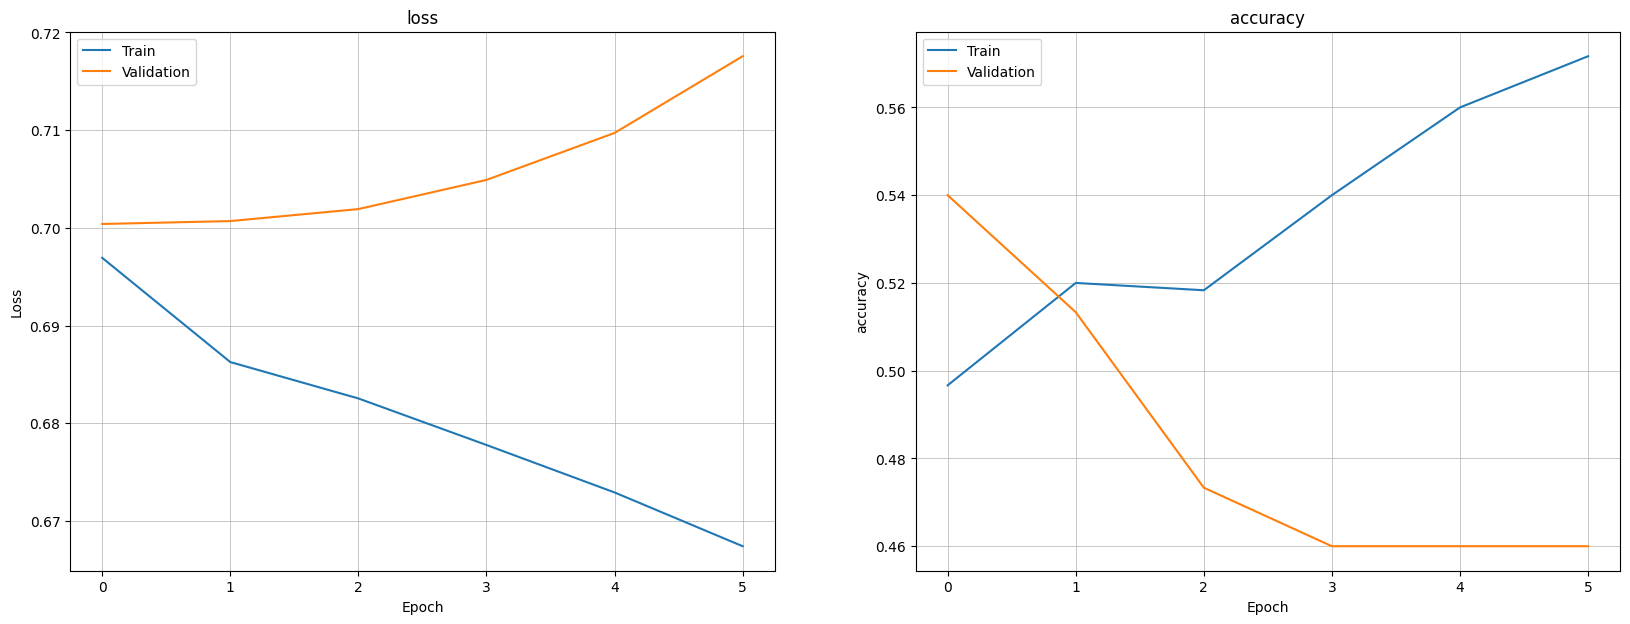

In [48]:
plot_history(history, metric='accuracy')

In [49]:
res = model.evaluate(X_test_pad, y_test, verbose=0)

print(f'The accuracy evaluated on the test set is of {res[1]*100:.3f}%')

2025-08-19 13:56:14.578942: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 30000000 exceeds 10% of free system memory.


The accuracy evaluated on the test set is of 50.667%


Because your new word2vec has been trained on a large corpus, it has a representation for many many words! Way more than with your small dataset, especially as you discarded words that were not present more than a given number of times in the train set. For that reason, you have way more embedded words in your train and test set, which makes each iteration longer than previously

In [50]:
!git add sentiment-analysis-with-word2vec.ipynb
! git commit -m "sentiment analysis_0"
! git push oorigin master

[master b0ad649] sentiment analysis_0
 1 file changed, 502 insertions(+), 48 deletions(-)
fatal: 'oorigin' does not appear to be a git repository
fatal: Could not read from remote repository.

Please make sure you have the correct access rights
and the repository exists.
